# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It extends the notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Creating GWL plots

21/07/2021

*J. Fernández* - [Santander Meteorology Group](http://www.meteo.unican.es). Instituto de Física de Cantabria, CSIC-UC, Santander, Spain.

> This notebook is a companion of the article _Implementation of FAIR principles in the IPCC: The WGI AR6 Atlas repository_ by Itubide et al., submitted to Scientific Data. It shows how to reuse the repository resources to create GWL plots as shown in the panels of Figure 3.

Global Warming Level (GWL) plots summarize the regional climate sensitivity of changes in different variables as a function of global mean surface air temperature changes. Decadal mean changes for the different members of a multimodel ensemble provide the sample to study the relationship between regional climate sensitivity and GWL. These plots are generated by the IPCC WGI AR6 Interactive Atlas (http://interactive-atlas.ipcc.ch) and are reproduced in this notebook using the data available in the Atlas repository. As in the interactive Atlas, the notebook allows to set different variables (tas or pr), masks (land, sea, landsea), scenarios, reference regions, etc.

### Import packages

In [1]:
import glob
import json
import matplotlib.pyplot as plt
import os.path
import pandas as pd
from matplotlib import cm
from sklearn import linear_model
from urllib.request import urlopen

### Set parameters

In [2]:
var = 'tas'
mask = 'landsea'
project = 'CMIP6' # CMIP5, CMIP6
project_gsat = 'CMIP6' # CMIP5 or CMIP6
scenario = 'ssp585' # e.g. ssp585 or rcp45
region = 'MED'
season = 'Annual'
period_hist = slice('1850','1900')

The following, in principle, require no modification. It is just information for labels and season selection.

In [3]:
longname = dict(pr = 'Precipitation', tas = 'Near surface temperature')
units = dict(pr='%', tas='K')
months = dict(DJF=[1,2,12], MAM=[3,4,5], JJA=[6,7,8], SON=[9,10,11], Annual=range(1,13))

### Compute decadal anomalies

We define first some commodity functions

In [4]:
def list_files(project, scenario, var, mask):
  '''List remote CSV files from the IPCC WGI Atlas repository'''
  repo = 'IPCC-WG1/Atlas'
  tag = 'v2.0-final'
  basedir = f'datasets-aggregated-regionally/data/{project}/{project}_{var}_{mask}'
  contents_url = f'https://api.github.com/repos/{repo}/contents/{basedir}?ref={tag}'
  raw_baseurl = f'https://raw.githubusercontent.com/{repo}/{tag}/{basedir}/'
  data_json = json.loads(urlopen(contents_url).read())
  file_list = [raw_baseurl + item['name'] for item in data_json if scenario in item['name']]
  return(file_list)

def read_files(csvlist):
  '''Concatenates a list of CSV files as a dataframe'''
  csvdata = [pd.read_csv(csv, comment = '#') for csv in csvlist]
  csvdata = pd.concat(csvdata)
  csvdata['date'] = pd.to_datetime(csvdata['date'], format='%Y-%m')
  return(csvdata.set_index('date'))

def get_average(df, period, region = 'world', season = 'Annual'):
  '''Computes the seasonal average for a given region and period'''
  rval = df.loc[period,region]
  return(rval[rval.index.month.isin(months[season])].mean())

def get_run(filepath):
  '''Extracts member identifier from filename'''
  return( filepath.split('_')[-1].split('.')[0] )

def get_model(filepath):
  '''Extracts model name from filename'''
  return( filepath.split('_')[-3].split('.')[0] )

We can now compute decadal anomalies for the selected variable and for global mean surface air temperature as reference. The abscissas in this plot always represent the GWL so the variable is always `tas` and no mask is applied (`landsea`), regardless of the selection above for the variable in the Y axis.

In [5]:
%%time

def decadal_anomalies(project, scenario, var = 'tas', mask = 'landsea', region = 'world', season = 'Annual', relative = False):
  data = pd.DataFrame(columns = ['model', 'run', 'decade', region])
  files_scen = list_files(project, scenario, var, mask)
  for scenfile in files_scen:
    histfile = scenfile.replace(scenario, 'historical')
    member_data = read_files([histfile, scenfile])
    reference_value = get_average(member_data, period_hist, region, season)
    # get decadal anomalies w.r.t. reference
    for decade_start in range(2010,2099,10):
      decade = slice(str(decade_start), str(decade_start+9))
      dfrow = dict(
        model = get_model(scenfile),
        run = get_run(scenfile),
        decade = f'{decade.start}-{decade.stop}'
      )
      dfrow[region] = get_average(member_data, decade, region, season) - reference_value
      if relative:
        dfrow[region] = 100. * dfrow[region] / reference_value
      data = data.append(dfrow, ignore_index=True)
  return(data.set_index(['model', 'run', 'decade']))

ydata = decadal_anomalies(project, scenario, var, mask, region, season, relative = var=='pr')
xdata = decadal_anomalies(project_gsat, scenario) # the rest of arguments default to GSAT
data = pd.concat([xdata, ydata], axis=1, join='inner').dropna()

CPU times: user 7.34 s, sys: 844 ms, total: 8.18 s
Wall time: 16.1 s


We have now all the information we need to construct the GWL Plot in a single dataframe object:

In [6]:
data

world       MED
model       run      decade                       
ACCESS-CM2  r1i1p1f1 2010-2019  1.042027  1.043156
                     2020-2029  1.487619  1.661756
                     2030-2039  1.813544  1.979031
                     2040-2049  2.320052  2.404306
                     2050-2059  2.954435  3.321714
...                                  ...       ...
UKESM1-0-LL r1i1p1f2 2050-2059  3.573586  3.947863
                     2060-2069  4.385995  4.806280
                     2070-2079  5.190636  5.654346
                     2080-2089  6.012670  6.673038
                     2090-2099  6.866036  7.715313

[306 rows x 2 columns]

### GWL Plot

The GWL Plot is now just a scatterplot of the region vs. the world columns in this dataframe. We might colour the individual points according to their decade, and add decadal averages on top, as in the Interactive Atlas.

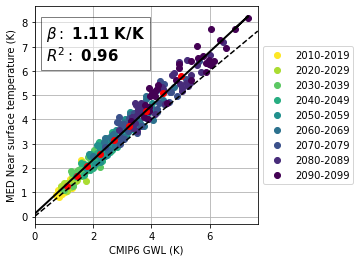

In [7]:
decades = sorted(list(set(data.index.get_level_values(2))))
colors = cm.get_cmap('viridis_r', len(decades))
fig, ax = plt.subplots(figsize=(4,4))
h = []
for k,decade in enumerate(decades):
  decdata = data.xs(decade, level=2)
  h.append(ax.scatter(x=decdata['world'], y=decdata[region], color=colors(k)))
# Set legend outside the plot
ax.legend(h, decades, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# Add decadal means
decadal_means = data.groupby('decade').mean()
ax.plot(decadal_means['world'], decadal_means[region], 'or')
# Add linear fit
lm = linear_model.LinearRegression()
X = data['world'].values.reshape(-1, 1)
y = data[region]
model = lm.fit(X, y)
ax.set_xlim(left=0)
#ax.set_xlim(0,8)
#ax.set_ylim(0,16)
ax.text(0.05, 0.92, '$\\beta:$ %.2f %s/K\n$R^2:$ %4.2f' % (model.coef_, units[var], lm.score(X, y)), color='k',
        verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, 
        fontsize=15, fontweight = 'bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5})
X[0] = 0
ax.plot(X, model.predict(X), color = 'k', linewidth = 2)
# Grid and labels
ax.set_axisbelow(True)
ax.grid()
ax.axline((1, 1), slope=1, ls="--", c="k")
plt.xlabel(f'{project_gsat} GWL (K)')
plt.ylabel(f'{region} {longname[var]} ({units[var]})')
plt.savefig(f'GWL-plot-{project}_{scenario}_{region}_{var}_{mask}.png', dpi=150, bbox_inches = 'tight', facecolor = 'w')